# Import Packages and Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

transcript = pd.read_pickle(r'data\02_stg\stg_transcript.pkl')
portfolio = pd.read_pickle(r'data\02_stg\stg_portfolio_featurized.pkl')
transcript.head()


,customer_id,offer_id,event,time_hrs,transaction_amount,reward
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer received,168,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,offer viewed,192,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,NaN,transaction,228,22.16,NaN
3,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer received,336,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,offer viewed,372,NaN,NaN


# Wrangle Offers Data

In [3]:
#Drop the 'transaction' rows
offers = transcript[transcript['event'] != 'transaction']

# Drop the 'transaction_amount' column
offers = offers.drop('transaction_amount', axis=1)

df_pivot_offers = offers.pivot_table(index=['customer_id', 'offer_id'], 
                            values='time_hrs', 
                            columns='event', 
                            aggfunc='first').reset_index()

#Re order columns
df_pivot_offers = df_pivot_offers[['customer_id', 'offer_id', 'offer received', 'offer viewed', 'offer completed']]

#Rename columns
df_pivot_offers.columns = ['customer_id', 'offer_id', 'offer_received', 'offer_viewed', 'offer_completed']

#Sort columns by customer_id and offer_received to make customer segmentation easier
df_pivot_offers = df_pivot_offers.sort_values(by=['customer_id', 'offer_received'])

#Reset index
df_pivot_offers = df_pivot_offers.reset_index(drop=True)

df_pivot_offers.head()

,customer_id,offer_id,offer_received,offer_viewed,offer_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0


# Calculate Time to Completion

In [4]:
def time_to_complete(row):
    # Check if the offer was viewed
    offer_viewed = pd.notnull(row['offer_viewed'])
    # Check if the offer was completed
    offer_completed = pd.notnull(row['offer_completed'])
    
    # If the offer was viewed and completed, and the time of viewing is less than or equal to the time of completion
    if offer_viewed and offer_completed and row['offer_viewed'] <= row['offer_completed']:
        # Return the time difference between completion and viewing
        return row['offer_completed'] - row['offer_viewed']
    # If the offer was not viewed but was completed
    # This is still important to calculate because we can use this to optimize the timing of push notifications
    elif offer_completed:
        # Return the time difference between completion and receiving the offer
        return row['offer_completed'] - row['offer_received']
    else:
        # If the offer was neither viewed nor completed, return NaN
        return np.nan

In [5]:
# Add column 'viewed_before_completion'. If the offer was viewed before it was completed, the value is 1, otherwise 0
# The less than or equal to assumption is because even if the offer was viewed slightly after completion, it means the customer
# is looking at their device in or around the time they are in the store. This is still a good sign of engagement.
def viewed_before_completion(row):
    # Check if the offer was completed
    if pd.notnull(row['offer_completed']):
        # If the offer was completed, check if it was also viewed and if it was viewed before or at the same time it was completed
        if pd.notnull(row['offer_viewed']) and row['offer_viewed'] <= row['offer_completed']:
            # If the offer was viewed before or at the same time it was completed, return 1
            return 1
        else:
            # If the offer was not viewed or was viewed after it was completed, return 0
            return 0
    else:
        # If the offer was not completed, return NaN
        return np.nan
df_pivot_offers['viewed_before_completion'] = df_pivot_offers.apply(viewed_before_completion, axis=1)
df_pivot_offers.head()

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,viewed_before_completion
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,0.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,0.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,0.0


# Join Offer Information to Offers

In [6]:
portfolio.head()

,offer_id,difficulty,reward,duration_days,duration_hrs,email,mobile,social,web,is_bogo,is_discount,is_informational
0,ae264e3637204a6fb9bb56bc8210ddfd,10,10,7,168,1,1,1,0,1,0,0
1,4d5c57ea9a6940dd891ad53e9dbe8da0,10,10,5,120,1,1,1,1,1,0,0
2,3f207df678b143eea3cee63160fa8bed,0,0,4,96,1,1,0,1,0,0,1
3,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,168,1,1,0,1,1,0,0
4,0b1e1539f2cc45b7b9fa7c272da2e1d7,20,5,10,240,1,0,0,1,0,1,0


In [7]:
# Drop 'duration_days' column
portfolio = portfolio.drop('duration_days', axis=1)

# Merge df_merged with the subset of portfolio
df_merged = pd.merge(df_pivot_offers, portfolio, on='offer_id', how='left')

# Created 'expiration' column
df_merged['expiration'] = df_merged['offer_received'] + df_merged['duration_hrs']

df_merged.head()

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,viewed_before_completion,difficulty,reward,duration_hrs,email,mobile,social,web,is_bogo,is_discount,is_informational,expiration
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,NaN,0,0,72,1,1,1,0,0,0,1,240.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,NaN,0,0,96,1,1,0,1,0,0,1,432.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,408.0,456.0,414.0,0.0,5,5,120,1,1,1,1,1,0,0,528.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,504.0,540.0,528.0,0.0,10,2,240,1,1,1,1,0,1,0,744.0
4,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,576.0,NaN,576.0,0.0,10,2,168,1,1,0,1,0,1,0,744.0


# Summarize Data

In [8]:
# Calculate the number of unique customers
num_customers = df_merged['customer_id'].nunique()
print(f'There are {num_customers} unique customers in the dataset.')

# Calculate the length of the experiment
end_hrs = offers['time_hrs'].max()
days, hours = divmod(end_hrs, 24)
print(f'The experiment lasted {days} days and {hours} hours.')

There are 16994 unique customers in the dataset.
The experiment lasted 29 days and 18 hours.


In [9]:
# Create new columns in df_merged
df_merged['viewed_before_completion_reward'] = df_merged.apply(
    lambda x: x['reward'] if x['viewed_before_completion'] == 1 else 0, axis=1)
df_merged['viewed_after_completion_reward'] = df_merged.apply(
    lambda x: x['reward'] if x['viewed_before_completion'] == 0 else 0, axis=1)

# Update the groupby function to include the new columns
offers_per_cust = df_merged.groupby('customer_id').agg(
    offers_received=('offer_id', 'count'),
    offers_viewed=('offer_viewed', 'count'),
    informational_offers=('is_informational', 'sum'),
    offers_completed=('offer_completed', 'count'),
    offers_viewed_before_completion=('viewed_before_completion', 'sum'),
    viewed_before_completion_reward=('viewed_before_completion_reward', 'sum'),
    viewed_after_completion_reward=('viewed_after_completion_reward', 'sum'),
    eligible_rewards=('reward', 'sum')
).reset_index().sort_values('offers_received', ascending=False)

# Calculate the percentage of offers viewed
offers_per_cust['percent_of_offers_viewed'] = offers_per_cust['offers_viewed'] / offers_per_cust['offers_received']

# Calculate the percentage of offers completed. Adjusting for information offers because they cannot be completed
offers_per_cust['percent_of_offers_completed'] = offers_per_cust['offers_completed'] / (offers_per_cust['offers_received'] - offers_per_cust['informational_offers'])

# Calculate the percentage of offers viewed before completion
offers_per_cust['percent_of_offers_viewed_before_completion'] = offers_per_cust['offers_viewed_before_completion'] / offers_per_cust['offers_completed']

offers_per_cust.to_csv(r'data\04_fct\fct_offers_per_customer.csv', index=False)
offers_per_cust.head()

,customer_id,offers_received,offers_viewed,informational_offers,offers_completed,offers_viewed_before_completion,viewed_before_completion_reward,viewed_after_completion_reward,eligible_rewards,percent_of_offers_viewed,percent_of_offers_completed,percent_of_offers_viewed_before_completion
14018,d24aac66f5404bc48728a207cee8b098,6,6,2,4,4.0,27,0,27,1.000000,1.0,1.000000
1652,199a0cb9068941d5a520b891e0d1e9ae,6,6,1,4,4.0,19,0,24,1.000000,0.8,1.000000
11554,ac76ca1ff69c456dad050ae58ad82647,6,4,1,2,2.0,8,0,20,0.666667,0.4,1.000000
8465,7f495962e50f40b1b76393c7c5343135,6,5,1,3,2.0,8,2,25,0.833333,0.6,0.666667
16126,f2c52d3d820c466aa70b414bf1b5510f,6,6,1,4,3.0,18,10,33,1.000000,0.8,0.750000


In [10]:
avg_per_offers_viewed = offers_per_cust['percent_of_offers_viewed'].mean()
print(f'On average, {avg_per_offers_viewed:.2%} of offers are viewed by customers.')
avg_per_offers_completed = offers_per_cust['percent_of_offers_completed'].mean()
print(f'On average, {avg_per_offers_completed:.2%} of offers are completed by customers.')

avg_offers_viewed_before_completion = offers_per_cust['percent_of_offers_viewed_before_completion'].mean()
print(f'On average, {avg_offers_viewed_before_completion:.2%} of offers are viewed before completion by customers.')

reward_budget = offers_per_cust['eligible_rewards'].sum()
print(f'The total reward budget for the experiment is ${reward_budget:,.2f}.')

sum_of_viewed_before_completion_reward = offers_per_cust['viewed_before_completion_reward'].sum()
print(f'The total reward amount claimed before viewing the offer was ${sum_of_viewed_before_completion_reward:,.2f}.')
sum_of_viewed_after_completion_reward = offers_per_cust['viewed_after_completion_reward'].sum()
print(f'The total reward amount claimed before viewing the offer was ${sum_of_viewed_after_completion_reward:,.2f}.')
total_claimed = sum_of_viewed_before_completion_reward + sum_of_viewed_after_completion_reward
print(f'The total reward amount claimed was ${total_claimed:,.2f}.')

per_budget_claimed = total_claimed / reward_budget
print(f'{per_budget_claimed:.2%} of the reward budget was claimed by customers.')


On average, 78.10% of offers are viewed by customers.
On average, 57.46% of offers are completed by customers.
On average, 73.08% of offers are viewed before completion by customers.
The total reward budget for the experiment is $266,204.00.
The total reward amount claimed before viewing the offer was $102,098.00.
The total reward amount claimed before viewing the offer was $40,320.00.
The total reward amount claimed was $142,418.00.
53.50% of the reward budget was claimed by customers.


In [11]:
# Calculate the number of customers who received a certain number of offers
customer_count = offers_per_cust.groupby('offers_received')['customer_id'].nunique().reset_index(name='num_customers')

#Calculate the percentage of customers who received a certain number of offers
customer_count['percent_customers'] = round(customer_count['num_customers'] / num_customers * 100, 2)

# Save the dataframe to a CSV file
customer_count.to_csv(r'data\04_fct\fct_customers_per_num_offers.csv', index=False)
customer_count

,offers_received,num_customers,percent_customers
0,1,172,1.01
1,2,1599,9.41
2,3,5038,29.65
3,4,6563,38.62
4,5,3180,18.71
5,6,442,2.60


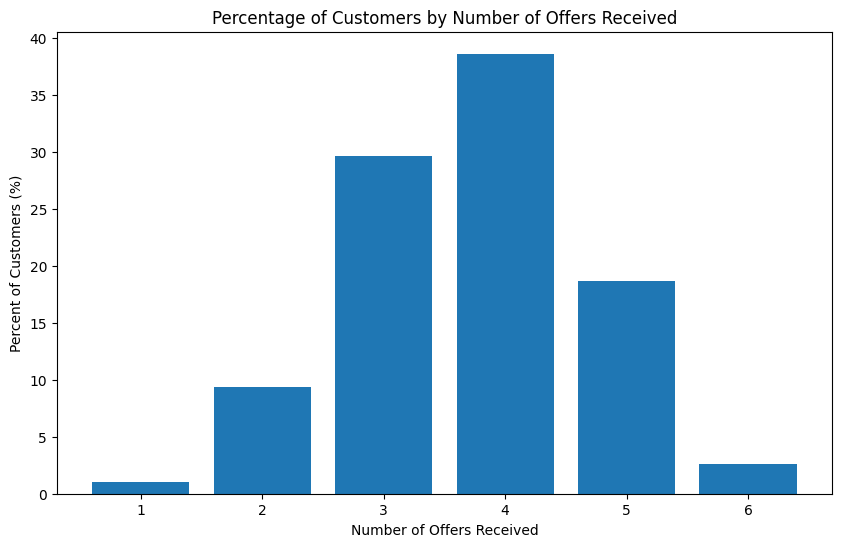

In [12]:
# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(customer_count['offers_received'], customer_count['percent_customers'])

# Add labels and title
plt.xlabel('Number of Offers Received')
plt.ylabel('Percent of Customers (%)')
plt.title('Percentage of Customers by Number of Offers Received')

# Show the plot
plt.show()

In [13]:
# filter df_merged on customer_id 'd24aac66f5404bc48728a207cee8b098'
customer = df_merged[df_merged['customer_id'] == 'd24aac66f5404bc48728a207cee8b098']
customer.head()

,customer_id,offer_id,offer_received,offer_viewed,offer_completed,viewed_before_completion,difficulty,reward,duration_hrs,email,mobile,social,web,is_bogo,is_discount,is_informational,expiration,viewed_before_completion_reward,viewed_after_completion_reward
52211,d24aac66f5404bc48728a207cee8b098,5a8bc65990b245e5a138643cd4eb9837,0.0,0.0,NaN,NaN,0,0,72,1,1,1,0,0,0,1,72.0,0,0
52212,d24aac66f5404bc48728a207cee8b098,4d5c57ea9a6940dd891ad53e9dbe8da0,168.0,168.0,180.0,1.0,10,10,120,1,1,1,1,1,0,0,288.0,10,0
52213,d24aac66f5404bc48728a207cee8b098,9b98b8c7a33c4b65b9aebfe6a799e6d9,336.0,354.0,360.0,1.0,5,5,168,1,1,0,1,1,0,0,504.0,5,0
52214,d24aac66f5404bc48728a207cee8b098,2906b810c7d4411798c6938adc9daaa5,408.0,408.0,438.0,1.0,10,2,168,1,1,0,1,0,1,0,576.0,2,0
52215,d24aac66f5404bc48728a207cee8b098,ae264e3637204a6fb9bb56bc8210ddfd,504.0,504.0,504.0,1.0,10,10,168,1,1,1,0,1,0,0,672.0,10,0
